## 1-Importing nessasry library

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os 
import glob
import cv2 
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, InputLayer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

import warnings
warnings.filterwarnings('ignore')

## 2-Visualizing images

# NOrmal Images : 1341


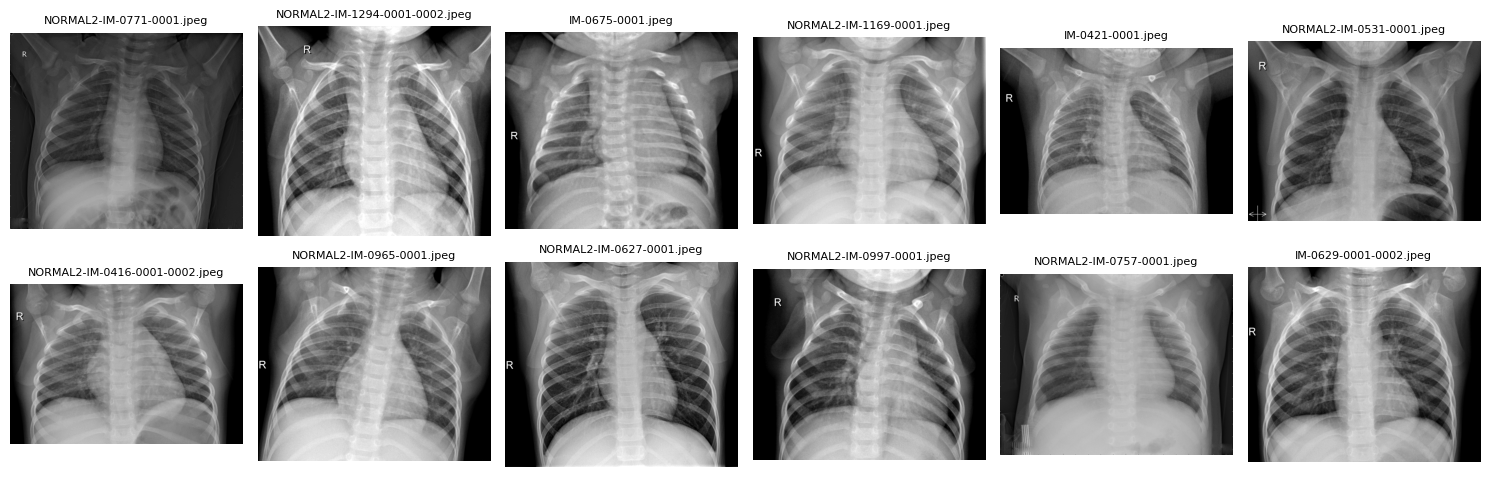

In [44]:
import os
import matplotlib.pyplot as plt

normal_folder_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'
images_name = os.listdir(normal_folder_path)
print(f'# NOrmal Images : {len(images_name)}')

fig, ax = plt.subplots(2, 6, figsize=(15, 5))
ax = ax.flatten()

for i in range(12):
    img_path = os.path.join(normal_folder_path, images_name[i])
    img = Image.open(img_path)
    ax[i].imshow(img , cmap = 'gray')
    ax[i].axis('off') 
    ax[i].set_title(images_name[i], fontsize=8)  

plt.tight_layout()
plt.show()


# PNEUMONIA Images : 3875


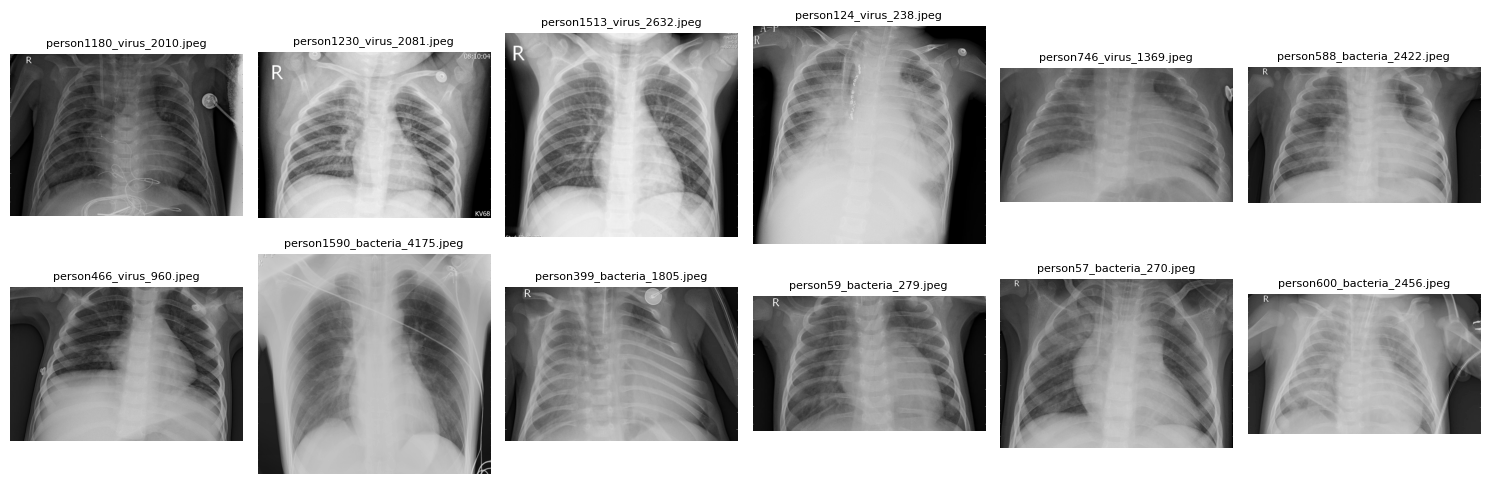

In [45]:
pne_folder_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
images_name = os.listdir(pne_folder_path)
print(f'# PNEUMONIA Images : {len(images_name)}')


fig, ax = plt.subplots(2, 6, figsize=(15, 5))
ax = ax.flatten()

for i in range(12):
    img_path = os.path.join(pne_folder_path, images_name[i])
    img = Image.open(img_path)
    ax[i].imshow(img , cmap = 'gray')
    ax[i].axis('off') 
    ax[i].set_title(images_name[i], fontsize=8)  

plt.tight_layout()
plt.show()


## 3-Load Images

In [46]:
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

## 3-Preprocessing Function

In [139]:
def get_images(path):
    X = []
    y = []
    for file in os.listdir(path):
        images = glob.glob(path + f'/{file}' + '/*')
        for image in images:
            image_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (150, 150))
            image_array = np.expand_dims(image_array, axis = -1)
            X.append(image_array)
            y.append(1 if file != 'NORMAL' else 0)
    return X, y

In [140]:
X_train, y_train = get_images(train_path)
X_val, y_val = get_images(val_path)
X_test, y_test = get_images(test_path)

In [141]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


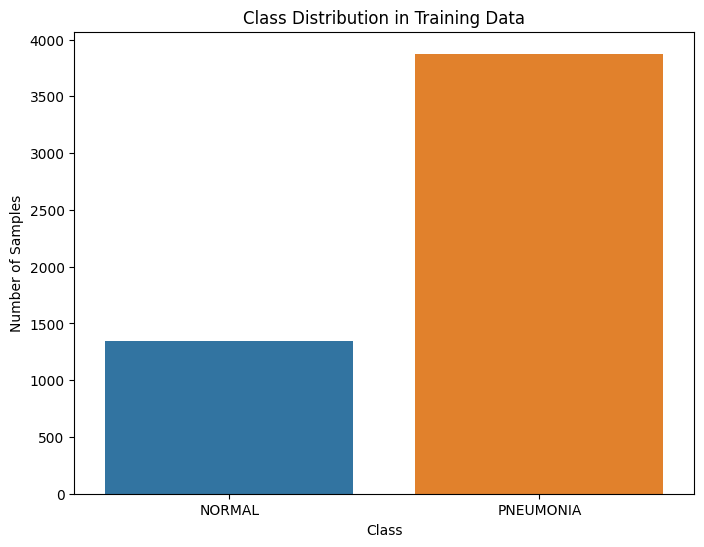

In [116]:
# Visualize class distribution
unique_labels, counts = np.unique(y_train, return_counts=True)
#unique_labels, counts = np.unique(test_labels_oversampled , return_counts=True)
#unique_labels, counts = np.unique(val_labels_oversampled , return_counts=True)


plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=counts)
plt.xticks(unique_labels, ['NORMAL', 'PNEUMONIA'])  # Set x-axis labels
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

## the Classes  is not balance

### Lets Handle Imbalance Data Using Class Weights 

In [142]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [143]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [131]:
# img_size = 255
# # resize data for deep learning 
# X_train = X_train.reshape(-1, img_size, img_size, 1)
# y_train = np.array(y_train)

# X_val = X_val.reshape(-1, img_size, img_size, 1)
# y_val = np.array(y_val)

# X_test = X_test.reshape(-1, img_size, img_size, 1)
# y_test = np.array(y_test)

In [144]:
import tensorflow
tensorflow.keras.backend.clear_session()

In [145]:
from sklearn.utils import compute_class_weight
class_weights = dict(zip(np.unique(y_train), compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## 4-Data Augmentation

In [146]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## 5-Model

In [147]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [148]:
import tensorflow as tf  # Import TensorFlow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping


In [149]:
K.clear_session()
##earlystopping = EarlyStopping(monitor='val_accuracy', patience = 2 , mode = 'max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(data_gen.flow(X_train, y_train, batch_size=32),
                       epochs = 15,
                       validation_data=datagen.flow(X_val, y_val),
                       callbacks=[learning_rate_reduction],
                       class_weight = class_weights
                  )

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - acc: 0.7434 - loss: 1.1252 - val_acc: 0.5000 - val_loss: 43.6320 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - acc: 0.8806 - loss: 0.3132 - val_acc: 0.5000 - val_loss: 53.7086 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.8936 - loss: 0.2720 - val_acc: 0.5000 - val_loss: 34.4152 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.9158 - loss: 0.2249 - val_acc: 0.6875 - val_loss: 0.4781 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - acc: 0.9180 - loss: 0.2358 - val_acc: 0.6875 - val_loss: 0.6104 - learning_rate: 0.0010
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - acc: 0.9351 - loss: 0.2091 - val_acc: 0.5000 - val_loss: 2.6551 - learning_rate: 0.0010
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.9299 - loss: 0.1919 - val_acc: 0.5625 - val_loss: 1.2111 - learning_ra

## 6-Model Evaluation

In [151]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8252 - loss: 0.5064
Loss of the model is -  0.5389496684074402
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8252 - loss: 0.5064
Accuracy of the model is -  82.69230723381042 %


## 7-Model Predict

In [152]:
import numpy as np

# Get the predicted probabilities for each class
predictions = model.predict(X_test)

# Get the class with the highest probability for each sample
predictions = np.argmax(predictions, axis=1) 

# Reshape the predictions 
predictions = predictions.reshape(1, -1)[0]

# Print the first 15 predictions
print(predictions[:15])

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 6-Analysis the model

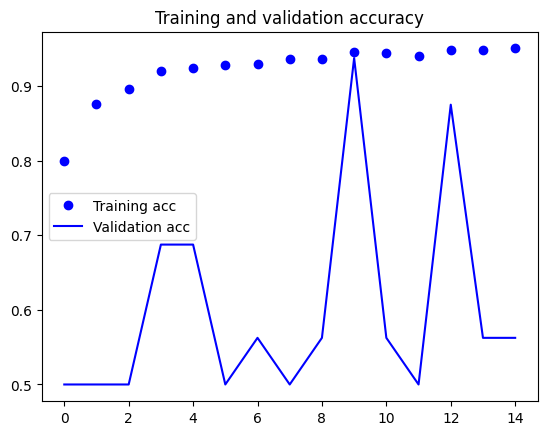

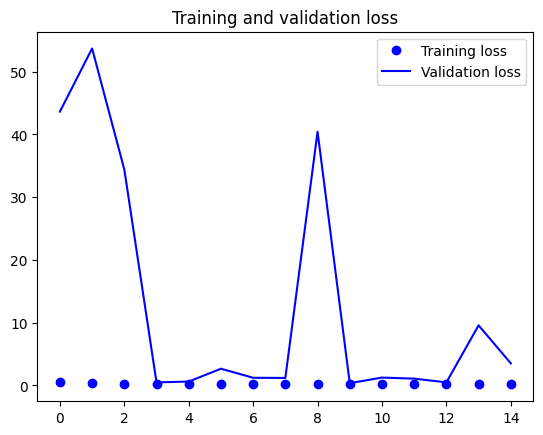

In [153]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [154]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.38      1.00      0.55       234
   Normal (Class 1)       0.00      0.00      0.00       390

           accuracy                           0.38       624
          macro avg       0.19      0.50      0.27       624
       weighted avg       0.14      0.38      0.20       624



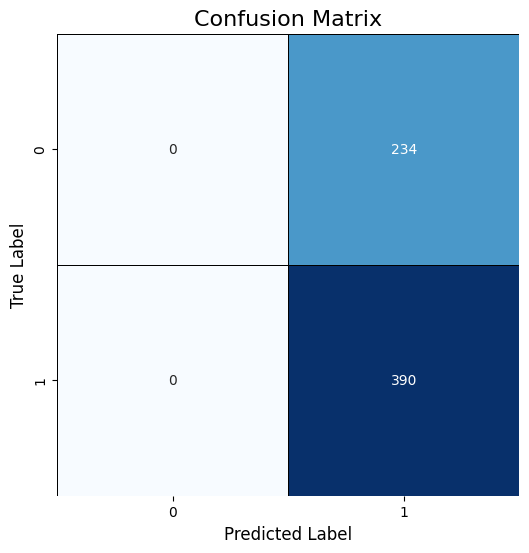

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



In [155]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred))

In [156]:
model.save('model.h5')

In [157]:
from keras.models import load_model
temp = load_model('model.h5')

In [158]:
temp.evaluate(X_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.8252 - loss: 0.5064


[0.5389496684074402, 0.8269230723381042]